In [1]:
from mylib.statistic_test import *

code_id = '0355 - Field Centroid Distribution'
loc = join(figpath, code_id)
mkdir(loc)
pass

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\0355 - Field Centroid Distribution is already existed!


# Get Nearest ROI

In [6]:
# import cdist
from scipy.spatial.distance import cdist

def get_nearest_roi(sfp_dir):
    with h5py.File(sfp_dir, 'r') as f:
        sfp = np.array(f['SFP'])
    
    centroids = np.zeros((sfp.shape[2], 2), dtype=np.float64)
    for i in range(sfp.shape[2]):
        vmax = np.max(sfp[:, :, i])
        x, y = np.where(sfp[:, :, i] == vmax)
        centroids[i, 0] = x[0]
        centroids[i, 1] = y[0]
    
    dist_matrix = cdist(centroids, centroids)
    np.fill_diagonal(dist_matrix, np.inf)
    nearest_indices = np.argmin(dist_matrix, axis=1)
    return nearest_indices, dist_matrix[(np.arange(len(nearest_indices)), nearest_indices)]

for i in range(len(f_CellReg_modi)):
    if i >= 1 :
        continue
    if f_CellReg_modi['Type'][i] != 'Real':
        continue
    f = f_CellReg_modi

    line = i
    cellreg_dir = f['cellreg_folder'][i]
    mouse = int(f['MiceID'][i])
    stage = f['Stage'][i]
    session = int(f['session'][i])
    maze_type = int(f['maze_type'][i])
    behavior_paradigm = f['paradigm'][i]
    
    index_map = GetMultidayIndexmap(
        mouse,
        stage=stage,
        session=session,
        i = i,
        occu_num=2
    )
    index_map[np.where((np.isnan(index_map))|(index_map < 0))] = 0

    if behavior_paradigm == 'CrossMaze':
        fdata = f1
    elif behavior_paradigm == 'ReverseMaze':
        fdata = f3
    elif behavior_paradigm == 'HairpinMaze':
        fdata = f4
    else:
        raise ValueError(f"Paradigm {behavior_paradigm} is not supported.")

    file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['Stage'] == stage) & (fdata['session'] == session))[0]
    
    if mouse in [11095, 11092]:
        file_indices = file_indices[3:]
    
    if stage == 'Stage 1+2':
        file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['session'] == session) & ((fdata['Stage'] == 'Stage 1') | (fdata['Stage'] == 'Stage 2')))[0]
        
    if stage == 'Stage 1' and mouse in [10212] and session == 2:
        file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['session'] == session) & (fdata['Stage'] == 'Stage 1') & (fdata['date'] != 20230506))[0]

    print(f"{i}: {mouse} {behavior_paradigm} {maze_type}")
    for fi in tqdm(file_indices):
        with open(fdata['Trace File'][fi], 'rb') as handle:
            trace = pickle.load(handle)

        sfp_dir = join(f_CellReg_modi['sfp_folder'][i], f"SFP{int(fdata['date'][fi])}.mat")
        nearest_indices, distances = get_nearest_roi(sfp_dir)
        trace['nearest_roi'] = nearest_indices+1
        trace['nearest_roi_distances'] = distances
        #print(trace['RawTraces'].shape[0],fdata['Trace File'][fi],  sfp_dir)
        assert trace['n_neuron'] == len(nearest_indices), f"Number of ROIs does not match: {trace['n_neuron']} != {len(nearest_indices)}"

        with open(fdata['Trace File'][fi], 'wb') as handle:
            pickle.dump(trace, handle)

0: 10209 CrossMaze 1


  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


In [21]:
with open(f_CellReg_modi['Trace File'][8], 'rb') as handle:
    trace1 = pickle.load(handle)

pf_all = trace1['place_field_all']
index_map_piece = trace1['index_map'][0, :].astype(np.int64)
field_info = trace1['field_info']
for i in range(len(pf_all)):
    pf = pf_all[i][0]
    if isinstance(pf, dict):
        print(np.unique(np.asarray(list(pf.keys()))), np.unique(field_info[0, np.where(field_info[0, :, 0] == index_map_piece[i])[0], 2]))

[ 390  563  913 1292 1736] [ 390.  563.  913. 1292. 1736.   nan]
[ 188 1166 1481] [ 188. 1166. 1481.   nan]
[1339 1559] [1339. 1559.   nan]
[] [nan]
[ 132  283  390  554  563  714  780 1141 1356 1465 1531 1828 2106] [ 132.  283.  390.  554.  563.  714.  780. 1141. 1356. 1465. 1531. 1828.
 2106.   nan]
[ 284  365  392  776  890  955 1142 1358 1513 1926] [ 284.  365.  392.  776.  890.  955. 1142. 1358. 1513. 1926.   nan]
[ 328  871  888 1133 1198 1264 1334 1634] [ 328.  871.  888. 1133. 1198. 1264. 1334. 1634.   nan]
[  70  242  329  729 1090 1482 1645 1705 2108] [  70.  242.  329.  729. 1090. 1482. 1645. 1705. 2108.   nan]
[  21   91  155  274  403  666  913  951 1134 1158 1329 1484 1750 2025
 2150] [  21.   91.  155.  274.  403.  666.  913.  951. 1134. 1158. 1329. 1484.
 1750. 2025. 2150.   nan]
[ 137  201  241  408  754  950 1009 1109 1181 1293 1412 1611 1927 2106] [ 137.  201.  241.  408.  754.  950. 1009. 1109. 1181. 1293. 1412. 1611.
 1927. 2106.   nan]
[  10  193  421  455  757  9

# Get Field Centroid Distance

15: 10212 HPb Thre 0.5   ---- 2025-09-07 20:50:28


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:01<00:00,  4.43it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S5-6
  Compute S5-7
  Compute S6-7


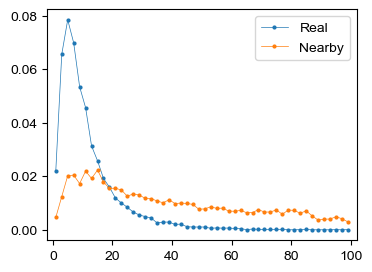

2025-09-07 20:51:14    -- Done.

15: 10212 HPf Thre 0.6   ---- 2025-09-07 20:51:14


100%|██████████| 7/7 [00:01<00:00,  4.14it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S5-6
  Compute S5-7
  Compute S6-7


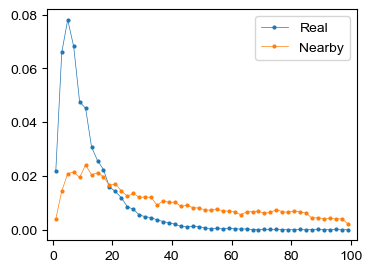

2025-09-07 20:52:05    -- Done.

15: 10212 HPb Thre 0.6   ---- 2025-09-07 20:52:06


100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S5-6
  Compute S5-7
  Compute S6-7


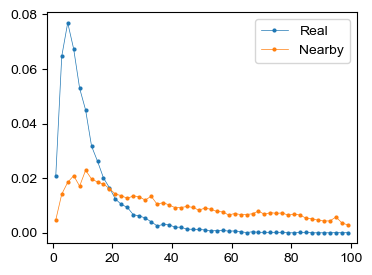

2025-09-07 20:52:52    -- Done.

15: 10212 HPf Thre 0.8   ---- 2025-09-07 20:52:52


100%|██████████| 7/7 [00:01<00:00,  3.70it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S5-6
  Compute S5-7
  Compute S6-7


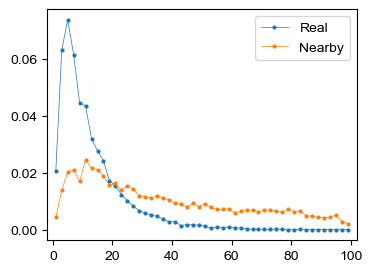

2025-09-07 20:53:47    -- Done.

15: 10212 HPb Thre 0.8   ---- 2025-09-07 20:53:47


100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S5-6
  Compute S5-7
  Compute S6-7


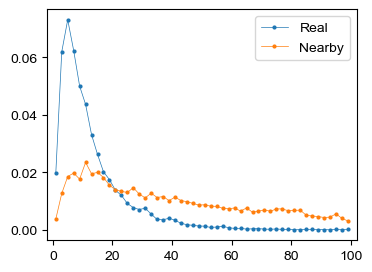

2025-09-07 20:54:37    -- Done.

14: 10209 HPf Thre 0.5   ---- 2025-09-07 20:54:37


100%|██████████| 7/7 [00:15<00:00,  2.19s/it]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S5-6
  Compute S5-7
  Compute S6-7


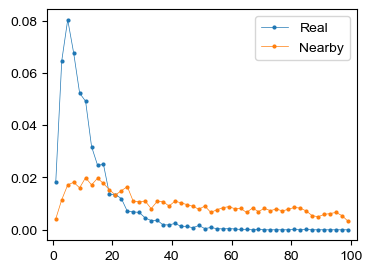

2025-09-07 20:55:18    -- Done.

14: 10209 HPb Thre 0.5   ---- 2025-09-07 20:55:18


100%|██████████| 7/7 [00:01<00:00,  4.87it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S5-6
  Compute S5-7
  Compute S6-7


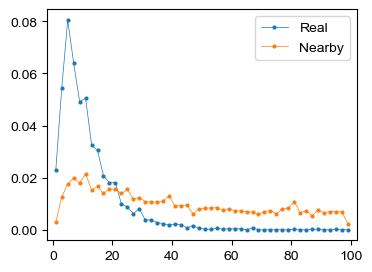

2025-09-07 20:55:38    -- Done.

14: 10209 HPf Thre 0.6   ---- 2025-09-07 20:55:39


100%|██████████| 7/7 [00:01<00:00,  4.12it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S5-6
  Compute S5-7
  Compute S6-7


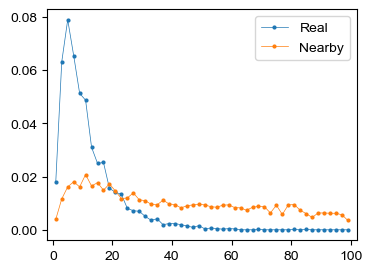

2025-09-07 20:56:07    -- Done.

14: 10209 HPb Thre 0.6   ---- 2025-09-07 20:56:07


100%|██████████| 7/7 [00:01<00:00,  4.60it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S5-6
  Compute S5-7
  Compute S6-7


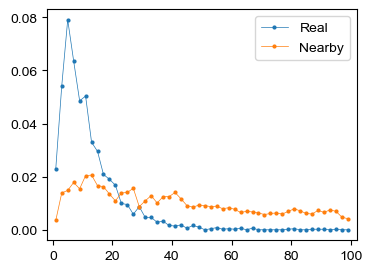

2025-09-07 20:56:27    -- Done.

14: 10209 HPf Thre 0.8   ---- 2025-09-07 20:56:28


100%|██████████| 7/7 [00:01<00:00,  4.42it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S5-6
  Compute S5-7
  Compute S6-7


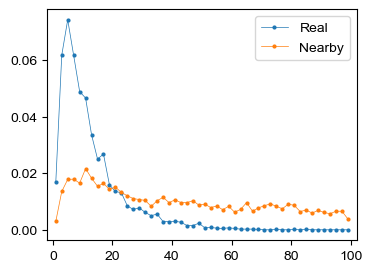

2025-09-07 20:56:55    -- Done.

14: 10209 HPb Thre 0.8   ---- 2025-09-07 20:56:55


100%|██████████| 7/7 [00:01<00:00,  4.63it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S5-6
  Compute S5-7
  Compute S6-7


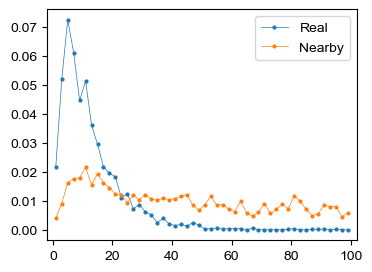

2025-09-07 20:57:16    -- Done.

13: 10234 MB Thre 0.5   ---- 2025-09-07 20:57:16


100%|██████████| 13/13 [00:02<00:00,  6.10it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S1-8
  Compute S1-9
  Compute S1-10
  Compute S1-11
  Compute S1-12
  Compute S1-13
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S2-8
  Compute S2-9
  Compute S2-10
  Compute S2-11
  Compute S2-12
  Compute S2-13
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S3-8
  Compute S3-9
  Compute S3-10
  Compute S3-11
  Compute S3-12
  Compute S3-13
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S4-8
  Compute S4-9
  Compute S4-10
  Compute S4-11
  Compute S4-12
  Compute S4-13
  Compute S5-6
  Compute S5-7
  Compute S5-8
  Compute S5-9
  Compute S5-10
  Compute S5-11
  Compute S5-12
  Compute S5-13
  Compute S6-7
  Compute S6-8
  Compute S6-9
  Compute S6-10
  Compute S6-11
  Compute S6-12
  Compute S6-13
  Compute S7-8
  Compute S7-9
  Compute S7-10
  Compute S7-11
  Compute S7-12
  Compute S7-13
  Compute S8-9
  Compute S8

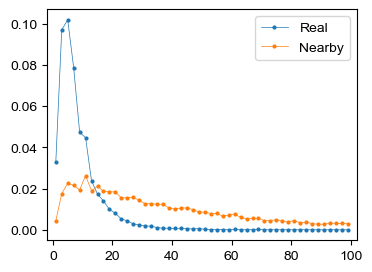

2025-09-07 20:59:25    -- Done.

13: 10234 MB Thre 0.6   ---- 2025-09-07 20:59:25


100%|██████████| 13/13 [00:01<00:00,  9.15it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S1-8
  Compute S1-9
  Compute S1-10
  Compute S1-11
  Compute S1-12
  Compute S1-13
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S2-8
  Compute S2-9
  Compute S2-10
  Compute S2-11
  Compute S2-12
  Compute S2-13
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S3-8
  Compute S3-9
  Compute S3-10
  Compute S3-11
  Compute S3-12
  Compute S3-13
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S4-8
  Compute S4-9
  Compute S4-10
  Compute S4-11
  Compute S4-12
  Compute S4-13
  Compute S5-6
  Compute S5-7
  Compute S5-8
  Compute S5-9
  Compute S5-10
  Compute S5-11
  Compute S5-12
  Compute S5-13
  Compute S6-7
  Compute S6-8
  Compute S6-9
  Compute S6-10
  Compute S6-11
  Compute S6-12
  Compute S6-13
  Compute S7-8
  Compute S7-9
  Compute S7-10
  Compute S7-11
  Compute S7-12
  Compute S7-13
  Compute S8-9
  Compute S8

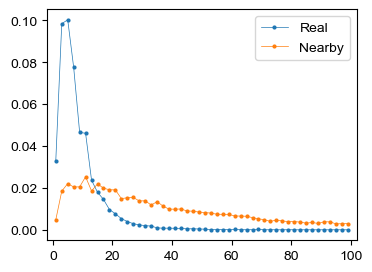

2025-09-07 21:01:37    -- Done.

13: 10234 MB Thre 0.8   ---- 2025-09-07 21:01:37


100%|██████████| 13/13 [00:01<00:00,  9.15it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S1-8
  Compute S1-9
  Compute S1-10
  Compute S1-11
  Compute S1-12
  Compute S1-13
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S2-8
  Compute S2-9
  Compute S2-10
  Compute S2-11
  Compute S2-12
  Compute S2-13
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S3-8
  Compute S3-9
  Compute S3-10
  Compute S3-11
  Compute S3-12
  Compute S3-13
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S4-8
  Compute S4-9
  Compute S4-10
  Compute S4-11
  Compute S4-12
  Compute S4-13
  Compute S5-6
  Compute S5-7
  Compute S5-8
  Compute S5-9
  Compute S5-10
  Compute S5-11
  Compute S5-12
  Compute S5-13
  Compute S6-7
  Compute S6-8
  Compute S6-9
  Compute S6-10
  Compute S6-11
  Compute S6-12
  Compute S6-13
  Compute S7-8
  Compute S7-9
  Compute S7-10
  Compute S7-11
  Compute S7-12
  Compute S7-13
  Compute S8-9
  Compute S8

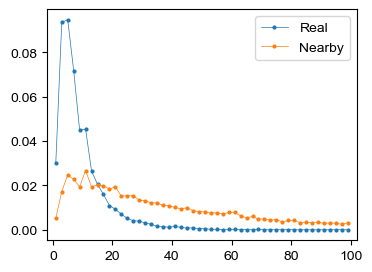

2025-09-07 21:03:54    -- Done.

12: 10234 MA Thre 0.5   ---- 2025-09-07 21:03:54


100%|██████████| 26/26 [00:07<00:00,  3.49it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S1-8
  Compute S1-9
  Compute S1-10
  Compute S1-11
  Compute S1-12
  Compute S1-13
  Compute S1-14
  Compute S1-15
  Compute S1-16
  Compute S1-17
  Compute S1-18
  Compute S1-19
  Compute S1-20
  Compute S1-21
  Compute S1-22
  Compute S1-23
  Compute S1-24
  Compute S1-25
  Compute S1-26
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S2-8
  Compute S2-9
  Compute S2-10
  Compute S2-11
  Compute S2-12
  Compute S2-13
  Compute S2-14
  Compute S2-15
  Compute S2-16
  Compute S2-17
  Compute S2-18
  Compute S2-19
  Compute S2-20
  Compute S2-21
  Compute S2-22
  Compute S2-23
  Compute S2-24
  Compute S2-25
  Compute S2-26
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S3-8
  Compute S3-9
  Compute S3-10
  Compute S3-11
  Compute S3-12
  Compute S3-13
  Compute S3-14
  Compute S3-15
  Compute S3-16
  Compute S3-17
  Compute S3-

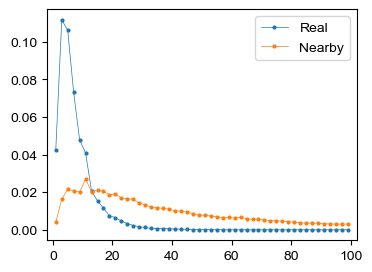

2025-09-07 21:14:47    -- Done.

12: 10234 MA Thre 0.6   ---- 2025-09-07 21:14:48


100%|██████████| 26/26 [00:07<00:00,  3.43it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S1-8
  Compute S1-9
  Compute S1-10
  Compute S1-11
  Compute S1-12
  Compute S1-13
  Compute S1-14
  Compute S1-15
  Compute S1-16
  Compute S1-17
  Compute S1-18
  Compute S1-19
  Compute S1-20
  Compute S1-21
  Compute S1-22
  Compute S1-23
  Compute S1-24
  Compute S1-25
  Compute S1-26
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S2-8
  Compute S2-9
  Compute S2-10
  Compute S2-11
  Compute S2-12
  Compute S2-13
  Compute S2-14
  Compute S2-15
  Compute S2-16
  Compute S2-17
  Compute S2-18
  Compute S2-19
  Compute S2-20
  Compute S2-21
  Compute S2-22
  Compute S2-23
  Compute S2-24
  Compute S2-25
  Compute S2-26
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S3-8
  Compute S3-9
  Compute S3-10
  Compute S3-11
  Compute S3-12
  Compute S3-13
  Compute S3-14
  Compute S3-15
  Compute S3-16
  Compute S3-17
  Compute S3-

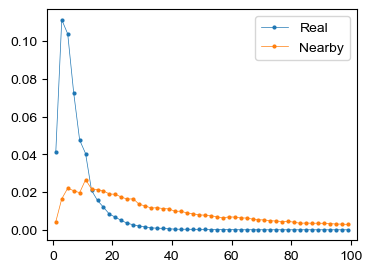

2025-09-07 21:26:18    -- Done.

12: 10234 MA Thre 0.8   ---- 2025-09-07 21:26:19


100%|██████████| 26/26 [00:04<00:00,  5.47it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S1-8
  Compute S1-9
  Compute S1-10
  Compute S1-11
  Compute S1-12
  Compute S1-13
  Compute S1-14
  Compute S1-15
  Compute S1-16
  Compute S1-17
  Compute S1-18
  Compute S1-19
  Compute S1-20
  Compute S1-21
  Compute S1-22
  Compute S1-23
  Compute S1-24
  Compute S1-25
  Compute S1-26
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S2-8
  Compute S2-9
  Compute S2-10
  Compute S2-11
  Compute S2-12
  Compute S2-13
  Compute S2-14
  Compute S2-15
  Compute S2-16
  Compute S2-17
  Compute S2-18
  Compute S2-19
  Compute S2-20
  Compute S2-21
  Compute S2-22
  Compute S2-23
  Compute S2-24
  Compute S2-25
  Compute S2-26
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S3-8
  Compute S3-9
  Compute S3-10
  Compute S3-11
  Compute S3-12
  Compute S3-13
  Compute S3-14
  Compute S3-15
  Compute S3-16
  Compute S3-17
  Compute S3-

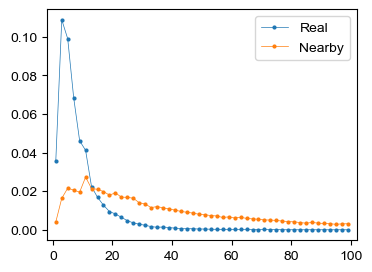

2025-09-07 21:37:02    -- Done.

11: 10232 MB Thre 0.5   ---- 2025-09-07 21:37:03


100%|██████████| 13/13 [00:02<00:00,  4.67it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S1-8
  Compute S1-9
  Compute S1-10
  Compute S1-11
  Compute S1-12
  Compute S1-13
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S2-8
  Compute S2-9
  Compute S2-10
  Compute S2-11
  Compute S2-12
  Compute S2-13
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S3-8
  Compute S3-9
  Compute S3-10
  Compute S3-11
  Compute S3-12
  Compute S3-13
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S4-8
  Compute S4-9
  Compute S4-10
  Compute S4-11
  Compute S4-12
  Compute S4-13
  Compute S5-6
  Compute S5-7
  Compute S5-8
  Compute S5-9
  Compute S5-10
  Compute S5-11
  Compute S5-12
  Compute S5-13
  Compute S6-7
  Compute S6-8
  Compute S6-9
  Compute S6-10
  Compute S6-11
  Compute S6-12
  Compute S6-13
  Compute S7-8
  Compute S7-9
  Compute S7-10
  Compute S7-11
  Compute S7-12
  Compute S7-13
  Compute S8-9
  Compute S8

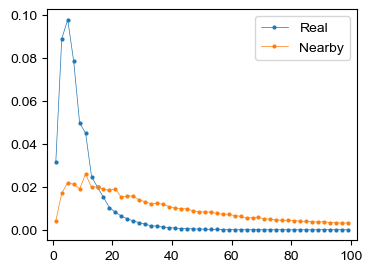

2025-09-07 21:44:24    -- Done.

11: 10232 MB Thre 0.6   ---- 2025-09-07 21:44:24


100%|██████████| 13/13 [00:02<00:00,  6.21it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S1-8
  Compute S1-9
  Compute S1-10
  Compute S1-11
  Compute S1-12
  Compute S1-13
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S2-8
  Compute S2-9
  Compute S2-10
  Compute S2-11
  Compute S2-12
  Compute S2-13
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S3-8
  Compute S3-9
  Compute S3-10
  Compute S3-11
  Compute S3-12
  Compute S3-13
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S4-8
  Compute S4-9
  Compute S4-10
  Compute S4-11
  Compute S4-12
  Compute S4-13
  Compute S5-6
  Compute S5-7
  Compute S5-8
  Compute S5-9
  Compute S5-10
  Compute S5-11
  Compute S5-12
  Compute S5-13
  Compute S6-7
  Compute S6-8
  Compute S6-9
  Compute S6-10
  Compute S6-11
  Compute S6-12
  Compute S6-13
  Compute S7-8
  Compute S7-9
  Compute S7-10
  Compute S7-11
  Compute S7-12
  Compute S7-13
  Compute S8-9
  Compute S8

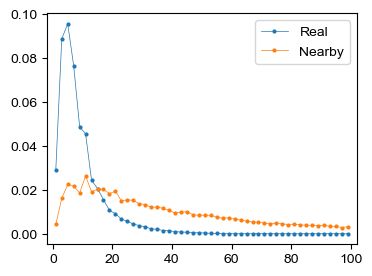

2025-09-07 21:52:09    -- Done.

11: 10232 MB Thre 0.8   ---- 2025-09-07 21:52:09


100%|██████████| 13/13 [00:01<00:00,  6.66it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S1-8
  Compute S1-9
  Compute S1-10
  Compute S1-11
  Compute S1-12
  Compute S1-13
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S2-8
  Compute S2-9
  Compute S2-10
  Compute S2-11
  Compute S2-12
  Compute S2-13
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S3-8
  Compute S3-9
  Compute S3-10
  Compute S3-11
  Compute S3-12
  Compute S3-13
  Compute S4-5
  Compute S4-6
  Compute S4-7
  Compute S4-8
  Compute S4-9
  Compute S4-10
  Compute S4-11
  Compute S4-12
  Compute S4-13
  Compute S5-6
  Compute S5-7
  Compute S5-8
  Compute S5-9
  Compute S5-10
  Compute S5-11
  Compute S5-12
  Compute S5-13
  Compute S6-7
  Compute S6-8
  Compute S6-9
  Compute S6-10
  Compute S6-11
  Compute S6-12
  Compute S6-13
  Compute S7-8
  Compute S7-9
  Compute S7-10
  Compute S7-11
  Compute S7-12
  Compute S7-13
  Compute S8-9
  Compute S8

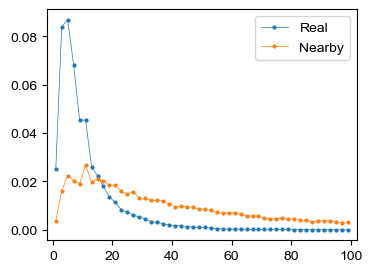

2025-09-07 21:59:59    -- Done.

10: 10232 MA Thre 0.5   ---- 2025-09-07 22:00:00


100%|██████████| 26/26 [00:08<00:00,  3.00it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S1-8
  Compute S1-9
  Compute S1-10
  Compute S1-11
  Compute S1-12
  Compute S1-13
  Compute S1-14
  Compute S1-15
  Compute S1-16
  Compute S1-17
  Compute S1-18
  Compute S1-19
  Compute S1-20
  Compute S1-21
  Compute S1-22
  Compute S1-23
  Compute S1-24
  Compute S1-25
  Compute S1-26
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S2-8
  Compute S2-9
  Compute S2-10
  Compute S2-11
  Compute S2-12
  Compute S2-13
  Compute S2-14
  Compute S2-15
  Compute S2-16
  Compute S2-17
  Compute S2-18
  Compute S2-19
  Compute S2-20
  Compute S2-21
  Compute S2-22
  Compute S2-23
  Compute S2-24
  Compute S2-25
  Compute S2-26
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S3-8
  Compute S3-9
  Compute S3-10
  Compute S3-11
  Compute S3-12
  Compute S3-13
  Compute S3-14
  Compute S3-15
  Compute S3-16
  Compute S3-17
  Compute S3-

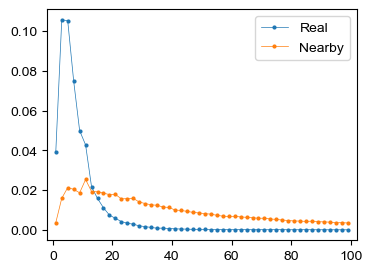

2025-09-07 22:37:12    -- Done.

10: 10232 MA Thre 0.6   ---- 2025-09-07 22:37:12


100%|██████████| 26/26 [00:06<00:00,  3.74it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S1-8
  Compute S1-9
  Compute S1-10
  Compute S1-11
  Compute S1-12
  Compute S1-13
  Compute S1-14
  Compute S1-15
  Compute S1-16
  Compute S1-17
  Compute S1-18
  Compute S1-19
  Compute S1-20
  Compute S1-21
  Compute S1-22
  Compute S1-23
  Compute S1-24
  Compute S1-25
  Compute S1-26
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S2-8
  Compute S2-9
  Compute S2-10
  Compute S2-11
  Compute S2-12
  Compute S2-13
  Compute S2-14
  Compute S2-15
  Compute S2-16
  Compute S2-17
  Compute S2-18
  Compute S2-19
  Compute S2-20
  Compute S2-21
  Compute S2-22
  Compute S2-23
  Compute S2-24
  Compute S2-25
  Compute S2-26
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S3-8
  Compute S3-9
  Compute S3-10
  Compute S3-11
  Compute S3-12
  Compute S3-13
  Compute S3-14
  Compute S3-15
  Compute S3-16
  Compute S3-17
  Compute S3-

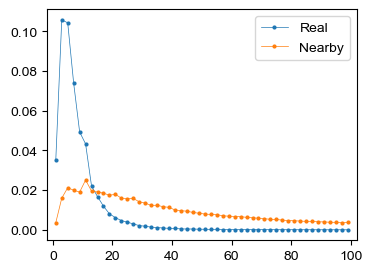

2025-09-07 23:17:39    -- Done.

10: 10232 MA Thre 0.8   ---- 2025-09-07 23:17:40


100%|██████████| 26/26 [00:05<00:00,  4.55it/s]


  Compute S1-2
  Compute S1-3
  Compute S1-4
  Compute S1-5
  Compute S1-6
  Compute S1-7
  Compute S1-8
  Compute S1-9
  Compute S1-10
  Compute S1-11
  Compute S1-12
  Compute S1-13
  Compute S1-14
  Compute S1-15
  Compute S1-16
  Compute S1-17
  Compute S1-18
  Compute S1-19
  Compute S1-20
  Compute S1-21
  Compute S1-22
  Compute S1-23
  Compute S1-24
  Compute S1-25
  Compute S1-26
  Compute S2-3
  Compute S2-4
  Compute S2-5
  Compute S2-6
  Compute S2-7
  Compute S2-8
  Compute S2-9
  Compute S2-10
  Compute S2-11
  Compute S2-12
  Compute S2-13
  Compute S2-14
  Compute S2-15
  Compute S2-16
  Compute S2-17
  Compute S2-18
  Compute S2-19
  Compute S2-20
  Compute S2-21
  Compute S2-22
  Compute S2-23
  Compute S2-24
  Compute S2-25
  Compute S2-26
  Compute S3-4
  Compute S3-5
  Compute S3-6
  Compute S3-7
  Compute S3-8
  Compute S3-9
  Compute S3-10
  Compute S3-11
  Compute S3-12
  Compute S3-13
  Compute S3-14
  Compute S3-15
  Compute S3-16
  Compute S3-17
  Compute S3-

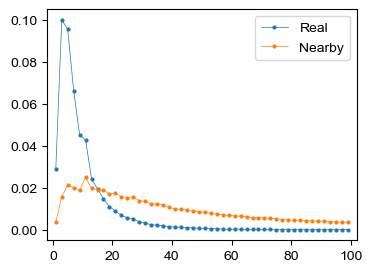

2025-09-07 23:49:10    -- Done.



In [2]:
def registered_fields_distribution(
    smooth_map_1: np.ndarray,
    smooth_map_2: np.ndarray,
    i: int,
    j: int, 
    place_field_all: list[dict],
    field_info: np.ndarray,
    field_reg: np.ndarray,
    index_map: np.ndarray,
    maze_type: int
):
    assert j > i, "j must be greater than i."
    center_i, center_j = [], []
    for n in range(len(place_field_all)):
        pf_i, pf_j = place_field_all[n][i], place_field_all[n][j]
        if isinstance(pf_i, dict) and isinstance(pf_j, dict):
            idx_i = np.where(
                (field_info[i, :, 0] == index_map[i, n]) &
                (field_reg[i, :] == 1) &
                (field_reg[j, :] == 1)
            )[0]
            idx_j = np.where(
                (field_info[j, :, 0] == index_map[j, n]) &
                (field_reg[j, :] == 1) &
                (field_reg[i, :] == 1)
            )[0]
            idx_i = idx_j = np.intersect1d(idx_i, idx_j)
            if len(idx_i) > 0:
                for idx in idx_i:
                    if np.isnan(field_info[i, idx, 2]) or np.isnan(field_info[j, idx, 2]):
                        raise ValueError("Field center is NaN.")
                    center_processed = int(field_info[i, idx, 2])
                    try:
                        field_region = np.asarray(pf_i[center_processed], np.int64)
                    except:
                        continue
                    cell_i = int(field_info[i, idx, 0])
                    cell_j = int(field_info[j, idx, 0])

                    centroid_i = field_region[np.argmax(smooth_map_1[cell_i-1, field_region-1])]
                    centroid_j = field_region[np.argmax(smooth_map_2[cell_j-1, field_region-1])]

                    center_i.append(centroid_i)
                    center_j.append(centroid_j)

    centroid_i = np.asarray(center_i, np.int64)
    centroid_j = np.asarray(center_j, np.int64)
    
    D = GetDMatrices(maze_type, 48)
    return D[(centroid_i-1, centroid_j-1)].astype(np.float64)
    
def find_nearest_fields(
    fields_of_cellA: dict,
    fields_of_cellB: dict,
    maze_type: int
):
    D = GetDMatrices(maze_type, 48)
    centers_A = np.asarray(list(fields_of_cellA.keys()), np.int64)
    centers_B = np.asarray(list(fields_of_cellB.keys()), np.int64)

    dist_mat = D[np.ix_(centers_A-1, centers_B-1)]
    return np.min(dist_mat, axis=1)

def get_field_distance_between_nearby_rois(
    trace1: dict,
    trace2: dict,
    i: int,
    j: int,
    index_map: np.ndarray,
    maze_type: int,
    dirs: str = 'cis'
):
    """Get field distance between an ROI in S1 (trace1) and the nearest neighbor of its corresponding ROI in S2 (trace2)."""
    assert trace1['maze_type'] == trace2['maze_type'], "Maze types do not match."
    assert 'nearest_roi' in trace1.keys(), "Trace1 does not have nearest_roi."
    assert 'nearest_roi' in trace2.keys(), "Trace2 does not have nearest_roi."
    assert 'nearest_roi_distances' in trace1.keys(), "Trace1 does not have nearest_roi_distances."
    assert 'nearest_roi_distances' in trace2.keys(), "Trace2 does not have nearest_roi_distances."

    index_map = index_map.astype(np.int64)
    dist_mat = []

    try:
        place_field_all_i = trace1['place_field_all']
        place_field_all_j = trace2['place_field_all']
    except:
        place_field_all_i = trace1[dirs]['place_field_all']
        place_field_all_j = trace2[dirs]['place_field_all']

    cell_idx = np.where((index_map[i, :] > 0)&(index_map[j, :] > 0))[0]
    nearby_cells = np.random.permutation(np.arange(trace2['n_neuron']))#nearby_cells = trace2['nearest_roi']
    for n in cell_idx:
        cell_i = index_map[i, n]
        cell_j = nearby_cells[index_map[j, n] - 1]
        pf_i = place_field_all_i[cell_i-1]
        pf_j = place_field_all_j[cell_j-1]
        if isinstance(pf_i, dict) and isinstance(pf_j, dict):
            if len(pf_i.keys()) == 0 or len(pf_j.keys()) == 0:
                dist_mat.append(np.array([]))
                continue
            dist_ij = find_nearest_fields(pf_i, pf_j, maze_type)
            dist_mat.append(dist_ij)
        else:
            dist_mat.append(np.array([]))
    
    return np.concatenate(dist_mat)

def compute_centroid_distance_main(
    i: int,
    f: pd.DataFrame = f_CellReg_modi,
    save_dir: str = loc,
    dirs: str = 'cis',
    thre: float = 0.75
):
    if f['Type'][i] != 'Real':
        return
    
    cellreg_dir = f['cellreg_folder'][i]
    mouse = int(f['MiceID'][i])
    stage = f['Stage'][i]
    session = int(f['session'][i])
    maze_type = int(f['maze_type'][i])
    behavior_paradigm = f['paradigm'][i]

    if behavior_paradigm == 'CrossMaze':
        paradm = 'MA' if maze_type == 1 else 'MB'
    elif behavior_paradigm == 'ReverseMaze':
        paradm = 'MAf' if dirs == 'cis' else 'MAb'
    elif behavior_paradigm == 'HairpinMaze':
        paradm = 'HPf' if dirs == 'cis' else 'HPb'

    if exists(join(save_dir, f"{i}_{mouse}_{paradm}.pkl")):
        return

    if behavior_paradigm == 'CrossMaze':
        fdata = f1
    elif behavior_paradigm == 'ReverseMaze':
        fdata = f3
    elif behavior_paradigm == 'HairpinMaze':
        fdata = f4
    else:
        raise ValueError(f"Paradigm {behavior_paradigm} is not supported.")

    file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['Stage'] == stage) & (fdata['session'] == session))[0]
    
    if mouse in [11095, 11092]:
        file_indices = file_indices[3:]
    
    if stage == 'Stage 1+2':
        file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['session'] == session) & ((fdata['Stage'] == 'Stage 1') | (fdata['Stage'] == 'Stage 2')))[0]
        
    if stage == 'Stage 1' and mouse in [10212] and session == 2:
        file_indices = np.where((fdata['MiceID'] == mouse) & (fdata['session'] == session) & (fdata['Stage'] == 'Stage 1') & (fdata['date'] != 20230506))[0]

    print(f"{i}: {mouse} {paradm} Thre {thre}   ---- {DateTime()}")
    traces = []
    for fi in tqdm(file_indices):
        with open(fdata['Trace File'][fi], 'rb') as handle:
            trace = pickle.load(handle)
        traces.append(trace)
    
    if paradm in ['MAf', 'MAb']:
        paradm_in_filename = 'MAf or MAb'
    elif paradm in ['HPf', 'HPb']:
        paradm_in_filename = 'HPf or HPb'
    else:
        paradm_in_filename = paradm

    mday_dir = f_CellReg_modi['Trace File'][i] if np.abs(thre-0.75) < 1e-2 else join(loc, "Diff_Threshold", f"THRE_{thre}_{i}_{mouse}_{paradm_in_filename}.pkl")
    with open(mday_dir, 'rb') as handle:
        trace_mdays = pickle.load(handle)
    
    res = {
        "MiceID": [],
        "Paradigm": [],
        "Field Distance": [],
        "Session i": [],
        "Session j": [],
        "Type": [],
        "Threshold": []
    }
    
    try:
        field_reg = trace_mdays['field_reg']
        field_info = trace_mdays['field_info']
        place_field_all = trace_mdays['place_field_all']
        index_map = trace_mdays['index_map']
    except:
        field_reg = trace_mdays[dirs]['field_reg']
        field_info = trace_mdays[dirs]['field_info']
        place_field_all = trace_mdays[dirs]['place_field_all']
        index_map = trace_mdays['index_map']

    for j in range(field_reg.shape[0]-1):
        for k in range(j+1, field_reg.shape[0]):
            # Get real distribution
            print(f"  Compute S{j+1}-{k+1}")
            try:
                dist_real = registered_fields_distribution(
                    traces[j]['smooth_map_all'],
                    traces[k]['smooth_map_all'],
                    j,
                    k,
                    place_field_all,
                    field_info,
                    field_reg,
                    index_map,
                    maze_type
                )
            except:
                dist_real = registered_fields_distribution(
                    traces[j][dirs]['smooth_map_all'],
                    traces[k][dirs]['smooth_map_all'],
                    j,
                    k,
                    place_field_all,
                    field_info,
                    field_reg,
                    index_map,
                    maze_type
                )
            dist_nearby = get_field_distance_between_nearby_rois(
                traces[j],
                traces[k],
                j,
                k,
                index_map=index_map,
                maze_type=maze_type,
                dirs=dirs
            )
            res['MiceID'].append(np.repeat(mouse, dist_real.shape[0]+dist_nearby.shape[0]))
            res['Paradigm'].append(np.repeat(paradm, dist_real.shape[0]+dist_nearby.shape[0]))
            res['Field Distance'].append(np.concatenate([dist_real, dist_nearby]))
            res['Type'].append(np.repeat('Real', dist_real.shape[0]))
            res['Type'].append(np.repeat('Nearby', dist_nearby.shape[0]))
            res['Session i'].append(np.repeat(j+1, dist_real.shape[0]+dist_nearby.shape[0]))
            res['Session j'].append(np.repeat(k+1, dist_real.shape[0]+dist_nearby.shape[0]))
            res['Threshold'].append(np.repeat(thre, dist_real.shape[0]+dist_nearby.shape[0]))
    
    for k in res.keys():
        res[k] = np.concatenate(res[k])
    
    if exists(save_dir) == False:
        os.makedirs(save_dir)
    with open(join(save_dir, f"{i}_{mouse}_{paradm}.pkl"), 'wb') as handle:
        pickle.dump(res, handle)
        
    idx_real = np.where(res['Type'] == 'Real')[0]
    idx_nearby = np.where(res['Type'] == 'Nearby')[0]
    y, x = np.histogram(res['Field Distance'][idx_real], bins=50, range=(0, 100), density=True)
    x = (x[1:]+x[:-1])/2
    y2, x2 = np.histogram(res['Field Distance'][idx_nearby], bins=50, range=(0, 100), density=True)
    x2 = (x2[1:]+x2[:-1])/2
    plt.figure(figsize=(4, 3))
    plt.plot(x, y, label='Real', linewidth=0.5, marker='o', markersize=3, markeredgewidth=0)
    plt.plot(x2, y2, label='Nearby', linewidth=0.5, marker='o', markersize=3, markeredgewidth=0)
    plt.legend()
    plt.xlim(-2, 102)
    plt.show()
    print(f"{DateTime()}    -- Done.", end='\n\n')
    return res


for i in range(15, 9, -1):
    for thre in [0.5, 0.6, 0.8]:
        if f_CellReg_modi['paradigm'][i] == 'CrossMaze':
            compute_centroid_distance_main(i, thre=thre,save_dir=join(loc, f"Res Thre {thre}"))
        else:
            compute_centroid_distance_main(i, thre=thre, dirs='cis', save_dir=join(loc, f"Res Thre {thre}"))
            compute_centroid_distance_main(i, thre=thre, dirs='trs', save_dir=join(loc, f"Res Thre {thre}"))
